## Чтение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
corpus_filename = 'files/corpus.json'

In [131]:
with open(corpus_filename, 'r') as file:
    corpus_ = json.load(file)

In [132]:
frame_corpus_ = pd.DataFrame(corpus_['catalog'])

## EDA

In [133]:
frame_corpus_.head()

,article_id,title,category,tags,text
0,https://ria.ru/20230115/neft-1845019942.html,"Иран ограничит поставки дешевой нефти в Сирию,...",economy,"Экономика, Цены на нефть, Сирия, Иран, Дамаск ...","ВАШИНГТОН, 15 янв - РИА Новости. Иран ограничи..."
1,https://ria.ru/20230115/mestorozhdenie-1845012...,Итальянская нефтегазовая компания обнаружила н...,economy,"Экономика, Цены на нефть, Египет, Средиземное ...","РИМ, 15 янв - РИА Новости. Итальянская нефтега..."
2,https://ria.ru/20230115/inflyatsiya-1844997935...,Инфляция в России может приблизиться к пяти пр...,economy,"Россия, Экономика, Владимир Путин, Павел Зарубин","ПЕТРОПАВЛОВСК-КАМЧАТСКИЙ, 15 янв - РИА Новости..."
3,https://ria.ru/20230115/ekonomika-1844996743.html,Путин назвал ситуацию в российской экономике с...,economy,"Экономика, Цены на нефть, Владимир Путин, Паве...","ПЕТРОПАВЛОВСК-КАМЧАТСКИЙ, 15 янв — РИА Новости..."
4,https://ria.ru/20230115/neft-1844714708.html,Редкие сорта: азиаты скупают российскую арктич...,economy,"Экономика, Китай, Россия, Индия, Международное...","МОСКВА, 15 янв — РИА Новости, Наталья Дембинск..."


In [134]:
frame_corpus_.describe()

,article_id,title,category,tags,text
count,4244,4244,4244,4244,4244
unique,4244,4233,4,3966,4242
top,https://ria.ru/20230115/neft-1845019942.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...",sport,"ЗОЖ, Здоровье, Здоровье - Общество",
freq,1,7,1184,27,3


Количество уникальных заголовков равно 4233. Это связано с тем, что информация о одном и том же событии менялась ежедневно, при этом текст новости практически не изменялся - главная информация оставалась неизменной. Поэтому мы оставим ту новость из повторяющихся, которая наиболее ранняя по публикации, а остальные удалим

Обратим внимание на то, что уникальных текстов меньше, чем общее количество текстов. И также мы видим, что есть 3 "пустых" текста. Удалим их. 

In [135]:
title_reapiting_news = frame_corpus_[frame_corpus_['title'].duplicated(keep=False)]['title'].unique()
print(title_reapiting_news)

['"Газпром" подает газ через Украину на ГИС "Суджа" в подтвержденном объеме'
 'В России замедлилась годовая инфляция'
 'Рогозин назвал срок запуска российского аппарата на Луну'
 'В больнице сообщили о состоянии Никиты Михалкова'
 'Фильм "Сердце пармы" снова возглавил прокат в России и СНГ за выходные']


In [136]:
for title in title_reapiting_news:
    drop_index = frame_corpus_[frame_corpus_['title'] == title].iloc[1:, :].index
    frame_corpus_.drop(drop_index, axis=0, inplace=True)

In [137]:
drop_index = frame_corpus_[frame_corpus_['text'].duplicated(keep=False)].index
frame_corpus_.drop(drop_index, axis=0, inplace=True)

In [138]:
frame_corpus_.describe()

,article_id,title,category,tags,text
count,4230,4230,4230,4230,4230
unique,4230,4230,4,3955,4230
top,https://ria.ru/20230115/neft-1845019942.html,"Иран ограничит поставки дешевой нефти в Сирию,...",sport,"ЗОЖ, Здоровье, Здоровье - Общество","ВАШИНГТОН, 15 янв - РИА Новости. Иран ограничи..."
freq,1,1,1184,27,1


Теперь все тексты новостей уникальны, точно так же как и заголовки этих новостей

## Предобработка данных

In [3]:
import spacy
import re
import string

In [140]:
frame_corpus_.head()

,article_id,title,category,tags,text
0,https://ria.ru/20230115/neft-1845019942.html,"Иран ограничит поставки дешевой нефти в Сирию,...",economy,"Экономика, Цены на нефть, Сирия, Иран, Дамаск ...","ВАШИНГТОН, 15 янв - РИА Новости. Иран ограничи..."
1,https://ria.ru/20230115/mestorozhdenie-1845012...,Итальянская нефтегазовая компания обнаружила н...,economy,"Экономика, Цены на нефть, Египет, Средиземное ...","РИМ, 15 янв - РИА Новости. Итальянская нефтега..."
2,https://ria.ru/20230115/inflyatsiya-1844997935...,Инфляция в России может приблизиться к пяти пр...,economy,"Россия, Экономика, Владимир Путин, Павел Зарубин","ПЕТРОПАВЛОВСК-КАМЧАТСКИЙ, 15 янв - РИА Новости..."
3,https://ria.ru/20230115/ekonomika-1844996743.html,Путин назвал ситуацию в российской экономике с...,economy,"Экономика, Цены на нефть, Владимир Путин, Паве...","ПЕТРОПАВЛОВСК-КАМЧАТСКИЙ, 15 янв — РИА Новости..."
4,https://ria.ru/20230115/neft-1844714708.html,Редкие сорта: азиаты скупают российскую арктич...,economy,"Экономика, Китай, Россия, Индия, Международное...","МОСКВА, 15 янв — РИА Новости, Наталья Дембинск..."


### Удаление предложения типа "ГОРОД, дата - РИА Новости" перед основным текстом

In [141]:
def delete_first_text_sentence(text):
    return text.split('.', 1)[1].strip()

In [142]:
frame_corpus_['text'] = frame_corpus_['text'].apply(delete_first_text_sentence)

In [143]:
corpus = frame_corpus_.drop(["article_id", "tags"], axis=1)

In [144]:
corpus['text'] = corpus['text'].str.cat(corpus['title'])

In [145]:
corpus = corpus.drop('title', axis=1)

In [146]:
corpus

,category,text
0,economy,Иран ограничивает поставки дешевой нефти в Сир...
1,economy,Итальянская нефтегазовая компания Eni сообщила...
2,economy,Инфляция в России по результатам первого кварт...
3,economy,"Ситуация в российской экономике стабильная, го..."
4,economy,Индия и Китай начали приобретать у России редк...
...,...,...
4239,sport,Ученые Техасского университета в Хьюстоне (США...
4240,sport,От боли в тазобедренном суставе страдают не то...
4241,sport,"Пальцы рук нужно тренировать так же, как мышцы..."
4242,sport,Врач-терапевт Виктор Лишин рассказал о пользе ...


### Удаление знаков препинания

In [147]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [148]:
regex_punctuation = re.compile('[%s]' % re.escape(string.punctuation))
print(regex_punctuation)

re.compile('[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]')


In [149]:
corpus['text'] = [regex_punctuation.sub(' ', c) for c in corpus['text']]

### Удаление всех иностранных слов и слов древнерусского языка

In [150]:
ANCIENT_WORDS = ''.join(['Ü', 'ä', 'å', 'è', 'é', 'ë', 'ì', 'ñ',
                'ø', 'ü', 'ş', 'ų', 'Ž', 'α', 'і', 'ѣ', 'ә'
                ])
print(ANCIENT_WORDS)

ÜäåèéëìñøüşųŽαіѣә


In [151]:
regex_ancient_words = re.compile('[%s]' % re.escape(ANCIENT_WORDS))
print(regex_ancient_words)

re.compile('[ÜäåèéëìñøüşųŽαіѣә]')


In [152]:
corpus['text'] = [regex_ancient_words.sub(' ', c) for c in corpus['text']]

In [153]:
regex_foreign_words = re.compile(r'[a-zA-z0-9_]+')

In [154]:
corpus['text'] = [regex_foreign_words.sub(' ', c) for c in corpus['text']]

Сейчас все тексты представлены исключительно русским языком

### Удаление лишних символов

In [155]:
extra_char = []
for text in corpus['text']:
    char = re.findall(r'[^а-яёА-ЯЁ0-9\s]', text)
    for c in char:
        extra_char.append(c)
extra_char = np.unique(extra_char)

In [156]:
regex_extra_char = re.compile('|'.join(extra_char))
print(regex_extra_char)

re.compile('\x7f|«|\xad|°|±|·|º|»|×|ʼ|́|̆|\u200b|\u200d|\u200e|‑|‒|–|—|―|’|“|”|․|…|№|−|∙|❖|⠀|️')


In [157]:
corpus['text'] = [regex_extra_char.sub(' ', c) for c in corpus['text']]

### Удаление чисел

In [158]:
regex_dig = re.compile('[%s]' % re.escape(string.digits))

In [159]:
corpus['text'] = [regex_dig.sub('', c) for c in corpus['text']]

In [160]:
corpus['text'][0]

'Иран ограничивает поставки дешевой нефти в Сирию  удвоив цену для Дамаска  сообщает американская газета       со ссылкой на источники  знакомые с ситуацией  Как пишет издание  источники отметили  что Тегеран также попросил Дамаск платить за нефть заранее  отклонив новые запросы о поставках в кредит   Как сообщили источники  знакомые с ситуацией  в последние недели иранские чиновники заявили своим сирийским коллегам  что тем теперь придется платить больше за дополнительные поставки нефти на фоне наступления пика зимнего спроса  удвоив цену до рыночной ставки в более чем   долларов за баррель     сообщает газета в воскресенье  Кроме того  издание процитировало слова представителя Союза экспортеров нефти  газа и нефтехимической продукции в Тегеране Хамида Хоссейни  который заявил  что сейчас Иран сам находится  под давлением  и что  нет причин продавать Сирии по низким ценам   В декабре   года сирийские власти временно объявили о четырехдневной рабочей неделе в госучреждениях на фоне ост

### Удаление лишних пробелов

In [161]:
corpus['text'] = [re.sub(r' +', ' ', c) for c in corpus['text']]

### Токенизация и приведение слов к нормальной форме + переход у нижнему регистру

In [4]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [163]:
nlp = spacy.load('ru_core_news_sm')

In [228]:
corpus_tokens = []
for text in corpus['text']:
    doc_tokens = []
    doc = nlp(text)
    for token in doc:
        doc_tokens.append(
            morph.parse(token.text)[0].normal_form
            )
    corpus_tokens.append(doc_tokens)

In [229]:
corpus['tokenize_text'] = corpus_tokens

In [232]:
corpus.to_csv('files/tokenize_normal_corpus.csv')

### Удаление стоп-слов

In [128]:
corpus = pd.read_csv('files/tokenize_normal_corpus.csv')
corpus = corpus.drop('Unnamed: 0', axis=1)
corpus.rename(columns={'tokenize_text': 'lema_tokens'}, inplace=True)
corpus

,category,text,lema_tokens
0,economy,Иран ограничивает поставки дешевой нефти в Сир...,"['иран', 'ограничивать', 'поставка', 'дешёвый'..."
1,economy,Итальянская нефтегазовая компания сообщила об ...,"['итальянский', 'нефтегазовый', 'компания', 'с..."
2,economy,Инфляция в России по результатам первого кварт...,"['инфляция', 'в', 'россия', 'по', 'результат',..."
3,economy,Ситуация в российской экономике стабильная гор...,"['ситуация', 'в', 'российский', 'экономика', '..."
4,economy,Индия и Китай начали приобретать у России редк...,"['индия', 'и', 'китай', 'начать', 'приобретать..."
...,...,...,...
4225,sport,Ученые Техасского университета в Хьюстоне США ...,"['учёный', 'техасский', 'университет', 'в', 'х..."
4226,sport,От боли в тазобедренном суставе страдают не то...,"['от', 'боль', 'в', 'тазобедренный', 'сустав',..."
4227,sport,Пальцы рук нужно тренировать так же как мышцы ...,"['палец', 'рука', 'нужно', 'тренировать', 'так..."
4228,sport,Врач терапевт Виктор Лишин рассказал о пользе ...,"['врач', 'терапевт', 'виктор', 'лишина', 'расс..."


In [5]:
def str_to_list(s):
    return re.sub(r"[['\]\s]", '', s).split(',')

In [130]:
corpus['lema_tokens'] = corpus.lema_tokens.apply(str_to_list)

In [131]:
print(len(corpus['lema_tokens'][0]))

197


In [132]:
def remove_sw(text):
    return [token for token in text if token not in nlp.Defaults.stop_words]

In [133]:
corpus['lema_tokens'] = corpus.lema_tokens.apply(remove_sw)

In [134]:
print(len(corpus['lema_tokens'][0]))

134


In [135]:
corpus.drop('text', axis=1, inplace=True)
corpus.rename(columns={'lema_tokens': 'lema_tokens_without_sw'}, inplace=True)
corpus

,category,lema_tokens_without_sw
0,economy,"[иран, ограничивать, поставка, дешёвый, нефть,..."
1,economy,"[итальянский, нефтегазовый, компания, сообщить..."
2,economy,"[инфляция, россия, результат, первый, квартал,..."
3,economy,"[ситуация, российский, экономика, стабильный, ..."
4,economy,"[индия, китай, начать, приобретать, россия, ре..."
...,...,...
4225,sport,"[учёный, техасский, университет, хьюстон, сша,..."
4226,sport,"[боль, тазобедренный, сустав, страдать, пожило..."
4227,sport,"[палец, рука, тренировать, мышца, пресса, ягод..."
4228,sport,"[врач, терапевт, виктор, лишина, рассказать, п..."


In [136]:
corpus.describe()

,category,lema_tokens_without_sw
count,4230,4230
unique,4,4229
top,sport,"[официальный, курс, доллар, рубль, установленн..."
freq,1184,2


Видим, что появился один дубликат, удалим его

In [137]:
corpus[corpus['lema_tokens_without_sw'].duplicated(keep=False)]

,category,lema_tokens_without_sw
500,economy,"[официальный, курс, доллар, рубль, установленн..."
792,economy,"[официальный, курс, доллар, рубль, установленн..."


In [138]:
corpus.drop(500, axis=0, inplace=True)

In [139]:
corpus.to_csv('files/preprocessed_corpus.csv')

## Векторизация текстов

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
corpus = pd.read_csv('files/preprocessed_corpus.csv')
corpus.drop('Unnamed: 0', axis=1, inplace=True)
corpus['lema_tokens_without_sw'] = corpus.lema_tokens_without_sw.apply(str_to_list)
corpus

/tmp/ipykernel_53833/2262829559.py:2: FutureWarning: Possible nested set at position 1
  return re.sub(r"[['\]\s]", '', s).split(',')


,category,lema_tokens_without_sw
0,economy,"[иран, ограничивать, поставка, дешёвый, нефть,..."
1,economy,"[итальянский, нефтегазовый, компания, сообщить..."
2,economy,"[инфляция, россия, результат, первый, квартал,..."
3,economy,"[ситуация, российский, экономика, стабильный, ..."
4,economy,"[индия, китай, начать, приобретать, россия, ре..."
...,...,...
4224,sport,"[учёный, техасский, университет, хьюстон, сша,..."
4225,sport,"[боль, тазобедренный, сустав, страдать, пожило..."
4226,sport,"[палец, рука, тренировать, мышца, пресса, ягод..."
4227,sport,"[врач, терапевт, виктор, лишина, рассказать, п..."


In [8]:
tf_idf_vectorizer = TfidfVectorizer()
tf_idf_vector = tf_idf_vectorizer.fit_transform([" ".join(corpus['lema_tokens_without_sw'][i]) for i in corpus.index])

In [9]:
tf_idf_vectorizer.vocabulary_

{'иран': 12011,
 'ограничивать': 21669,
 'поставка': 26082,
 'дешёвый': 8360,
 'нефть': 20611,
 'сирия': 31751,
 'удвоить': 36040,
 'цена': 38522,
 'дамаск': 7799,
 'сообщать': 32658,
 'американский': 845,
 'газета': 6157,
 'ссылка': 33221,
 'источник': 12208,
 'знакомый': 11122,
 'ситуация': 31780,
 'писать': 24443,
 'издание': 11411,
 'отметить': 22830,
 'тегеран': 34496,
 'попросить': 25869,
 'платить': 24582,
 'заранее': 10674,
 'отклонить': 22761,
 'новый': 20889,
 'запрос': 10631,
 'кредит': 14721,
 'сообщить': 32663,
 'последний': 26020,
 'неделя': 19775,
 'иранский': 12016,
 'чиновник': 39055,
 'заявить': 10923,
 'сирийский': 31747,
 'коллега': 13791,
 'прийтись': 26957,
 'большой': 3115,
 'дополнительный': 9097,
 'фон': 37389,
 'наступление': 19469,
 'пик': 24350,
 'зимний': 11068,
 'спрос': 33122,
 'рыночный': 30379,
 'ставка': 33237,
 'доллар': 9005,
 'баррель': 2083,
 'воскресение': 5174,
 'процитировать': 27978,
 'слово': 32149,
 'представитель': 26598,
 'союз': 32874,
 'э

<BarContainer object of 40824 artists>

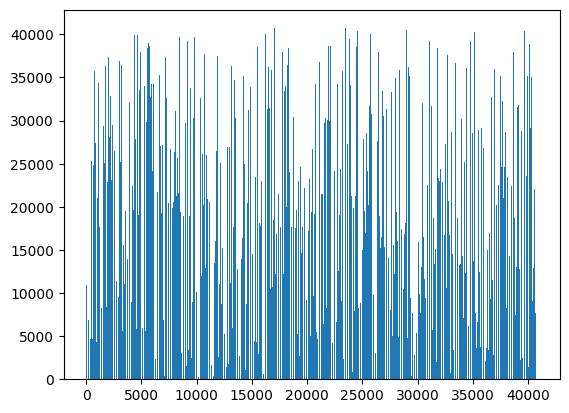

In [29]:
plt.bar(range(len(tf_idf_vectorizer.vocabulary_.values())), height=tf_idf_vectorizer.vocabulary_.values())

In [186]:
features_names = tf_idf_vectorizer.get_feature_names()

/home/arklykov/HSE4/DataScience/ds_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [187]:
dense = tf_idf_vector.todense()

In [188]:
tf_idf_dataframe = pd.DataFrame(dense, columns=features_names, index=corpus.index)

In [189]:
tf_idf_dataframe

,u2009,u202f,xa0,аана,ааний,ааны,аарон,аба,абазия,абаимов,...,ёжик,ёлка,ёлочный,ёля,ёмкий,ёмкость,ён,ёнджуна,ёсихитый,ёхэя
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016613,0.0,0.0,0.0,0.0
4227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Удалим символы, отвечающие за пробелы

In [190]:
tf_idf_dataframe.drop(['u2009', 'u202f', 'xa0'], axis=1, inplace=True)

In [213]:
tf_idf_dataframe

,аана,ааний,ааны,аарон,аба,абазия,абаимов,абакум,абаскалить,абашева,...,ёжик,ёлка,ёлочный,ёля,ёмкий,ёмкость,ён,ёнджуна,ёсихитый,ёхэя
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016613,0.0,0.0,0.0,0.0
4227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [214]:
tf_idf_dataframe.to_parquet('files/samples.parquet')

Используем LabelEncoder, чтобы закодировать категории новостей

In [210]:
from sklearn.preprocessing import LabelEncoder

In [211]:
category_encoder = LabelEncoder()
corpus['categeory_le'] = category_encoder.fit_transform(corpus['category'].values)

In [215]:
corpus.to_parquet('files/target.parquet')

## Построение моделей

In [2]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

In [3]:
X = pd.read_parquet('files/samples.parquet')
y = pd.read_parquet('files/target.parquet')
y = y['categeory_le']

In [4]:
y = y.astype(np.int8) 
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4229 entries, 0 to 4228
Series name: categeory_le
Non-Null Count  Dtype
--------------  -----
4229 non-null   int8 
dtypes: int8(1)
memory usage: 4.3 KB


In [5]:
X = X.astype(np.float32)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4229 entries, 0 to 4228
Columns: 40821 entries, аана to ёхэя
dtypes: float32(40821)
memory usage: 658.5 MB


<AxesSubplot: ylabel='Frequency'>

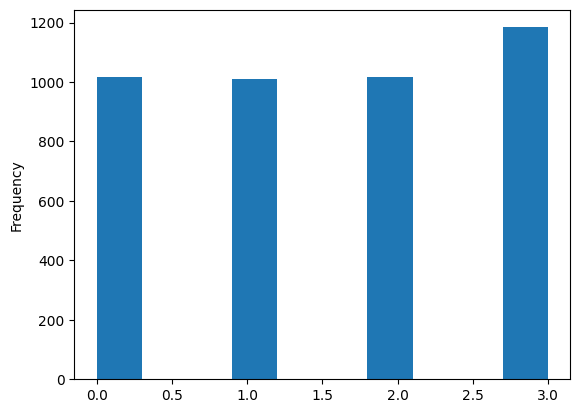

In [6]:
y.plot.hist()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

### Наивный Байес

По графику выше видим, что распределение "слов" не нормальное, поэтому использовать Gaussian Naive Bayes не разумно, кроме того известно, что датасет сбалансирован - количество объектов для разных классов одинаково, поэтому использование Complement Naive Bayes избыточно. Воспользуемся Multinomial Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB

In [9]:
multinomial_nb = MultinomialNB()

In [11]:
multinomial_nb.fit(X_train, y_train)

MultinomialNB()

In [12]:
y_pred = multinomial_nb.predict(X_test)

In [15]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f"precision: {precision_score(y_test, y_pred, average='micro') }")
print(f"recall: {recall_score(y_test, y_pred, average='micro')}")

accuracy: 0.9550827423167849
precision: 0.9550827423167849
recall: 0.9550827423167849


## KNeighborsClassifier

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
kn_classifier = KNeighborsClassifier()

In [18]:
kn_classifier.fit(X_train, y_train)
y_pred = kn_classifier.predict(X_test)

In [19]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f"precision: {precision_score(y_test, y_pred, average='micro') }")
print(f"recall: {recall_score(y_test, y_pred, average='micro')}")

accuracy: 0.9609929078014184
precision: 0.9609929078014184
recall: 0.9609929078014184


## LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
logistic_reg = LogisticRegression()

In [22]:
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

In [23]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f"precision: {precision_score(y_test, y_pred, average='micro') }")
print(f"recall: {recall_score(y_test, y_pred, average='micro')}")

accuracy: 0.9704491725768322
precision: 0.9704491725768322
recall: 0.9704491725768322


## RandomForestClassifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
random_forest = RandomForestClassifier()

In [26]:
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

In [27]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f"precision: {precision_score(y_test, y_pred, average='micro') }")
print(f"recall: {recall_score(y_test, y_pred, average='micro')}")

accuracy: 0.9491725768321513
precision: 0.9491725768321513
recall: 0.9491725768321513


## SVC

In [28]:
from sklearn.svm import SVC

In [29]:
svc = SVC()

In [30]:
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [31]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f"precision: {precision_score(y_test, y_pred, average='micro') }")
print(f"recall: {recall_score(y_test, y_pred, average='micro')}")

accuracy: 0.9728132387706856
precision: 0.9728132387706856
recall: 0.9728132387706856


## CatBoost

In [32]:
from catboost import CatBoostClassifier

In [33]:
cat_boost = CatBoostClassifier()

In [34]:
cat_boost.fit(X_train, y_train)
y_pred = cat_boost.predict(X_test)

/home/arklykov/HSE4/DataScience/ds_env/lib/python3.8/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.084201
0:	learn: 1.3060339	total: 3.94s	remaining: 1h 5m 37s
1:	learn: 1.2396844	total: 5.02s	remaining: 41m 43s
2:	learn: 1.1857344	total: 6.07s	remaining: 33m 37s
3:	learn: 1.1404864	total: 7.14s	remaining: 29m 36s
4:	learn: 1.0893548	total: 8.14s	remaining: 27m
5:	learn: 1.0579097	total: 9.32s	remaining: 25m 44s
6:	learn: 1.0212649	total: 10.8s	remaining: 25m 28s
7:	learn: 0.9876525	total: 11.8s	remaining: 24m 28s
8:	learn: 0.9572267	total: 13.4s	remaining: 24m 31s
9:	learn: 0.9333809	total: 14.6s	remaining: 24m
10:	learn: 0.9048550	total: 15.7s	remaining: 23m 31s
11:	learn: 0.8821482	total: 16.9s	remaining: 23m 10s
12:	learn: 0.8627251	total: 18.4s	remaining: 23m 18s
13:	learn: 0.8437009	total: 19.6s	remaining: 23m
14:	learn: 0.8230822	total: 20.7s	remaining: 22m 40s
15:	learn: 0.8057697	total: 22s	remaining: 22m 30s
16:	learn: 0.7892483	total: 23.1s	remaining: 22m 18s
17:	learn: 0.7735676	total: 24.4s	remaining: 22m 10s
18:	learn: 0.7585008	total: 25.5s	rema

In [35]:
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f"precision: {precision_score(y_test, y_pred, average='micro') }")
print(f"recall: {recall_score(y_test, y_pred, average='micro')}")

accuracy: 0.9550827423167849
precision: 0.9550827423167849
recall: 0.9550827423167849


## Выводы

Все модели показали хорошую результат по метрики accuracy, порядка 95-96% правильных угаданных категорий. Метрики accuracy, precision и recall отличаются не сильно, можно сказать, что не отличаются вовсе. Исходя из метрик, наилучшая модель для классификации текстов - SVC, наихудшая - RandomForest.